In [3]:
import scanpy as sc
import pycisTopic
from pycisTopic.cistopic_class import *
import pickle
import os
import anndata
import mudata
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pyvis.network import Network
from matplotlib.patches import ArrowStyle
from scipy.stats import fisher_exact
import seaborn as sns

In [4]:
def visualize_regulatory_network(metadata_df, importance_col='importance', weight_col='importance_TF2G',figure_size=(7, 7),
                               top_n=100, output_html='figures/network.html',title='SCENIC+ Regulatory Network',df_deg=None):
    """
    Visualize SCENIC+ regulatory network with TF-gene relationships
    
    Parameters:
        metadata_df: DataFrame with columns ['TF', 'gene', importance_col, 'region']
        importance_col: Column name for TF-gene importance scores
        top_n: Number of top interactions to visualize
        output_html: Output file name for interactive visualization
    """
    # Prepare data
    # Sort by the absolute importance and select top_n interactions

    df = metadata_df.sort_values(importance_col, ascending=False).head(top_n)
    #df = metadata_df.sort_values(importance_col, ascending=False)
    
    # Create network graph
    G = nx.DiGraph()
    
    # Add nodes and edges with importance as weight
    for _, row in df.iterrows():
        G.add_edge(row['TF'], row['Gene'], 
                  weight=row[weight_col],
                  title=f"Importance: {row[weight_col]:.2f}")
        
    degrees = dict(G.degree())
    max_degree = max(degrees.values()) if degrees else 1

    
    # Node colors (TFs in red, genes in blue)
    # Node colores, where TFs are orange and genes are magenta, not in df_deg are gray

    node_colors = {}
    node_edge_colors = {}
    node_edge_widths = {}

    for node in G.nodes():
        if node in df['TF'].unique() and node in df_deg['gene'].unique():
            if df_deg[df_deg['gene'] == node]['condition'].values[0] == 'UP':
                node_colors[node] = '#F6607C'
                node_edge_colors[node] = '#F6607C'  # Light red outline
                node_edge_widths[node] = 3
            else:
                node_colors[node] = '#B2DF8A'
                node_edge_colors[node] = '#B2DF8A'  # Light green outline
                node_edge_widths[node] = 3

        elif node in df['Gene'].unique() and node in df_deg['gene'].unique():
            if df_deg[df_deg['gene'] == node]['condition'].values[0] == 'UP':
                node_colors[node] = 'lightcoral'
                node_edge_colors[node] = 'lightcoral'
                node_edge_widths[node] = 3

            else:
                node_colors[node] = '#D2ECBB'
                node_edge_colors[node] = '#D2ECBB'
                node_edge_widths[node] = 3

        else:
            node_colors[node] = 'lightgray'  # For nodes not in df_deg
            node_edge_colors[node] = 'lightgray'
            node_edge_widths[node] = 0


    # node_colors = {
    #     node: 'orange' if node in df['TF'].unique() else 'magenta'
    #     for node in G.nodes()
    # }
    
    # Static visualization
    plt.figure(figsize=figure_size)
    pos = nx.spring_layout(G, k=0.1, iterations=50,scale=0.5)
    #pos = nx.kamada_kawai_layout(G, scale=0.8)
    
    # Draw nodes


    #node_sizes_d = [degrees[n] * 800 / max_degree for n in G.nodes()]
    #node size = abs log2 fold change in df_deg
    node_sizes = []
    for n in G.nodes():
        if n in df_deg['gene'].unique():
            fold_change = df_deg[df_deg['gene'] == n]['de_coef'].values[0]
            node_sizes.append(abs(fold_change) * 400 + degrees[n]*400 / max_degree)
        else:
            node_sizes.append(100)

    # node_sizes = [degrees[n] * 800 / max_degree for n in G.nodes()]
    # nx.draw_networkx_nodes(G, pos, node_color=[node_colors[n] for n in G.nodes()],
    #                                edgecolors=[node_edge_colors[n] for n in G.nodes()],
    #                 linewidths=[node_edge_widths[n] for n in G.nodes()],
    #                       node_size=node_sizes, alpha=0.8)


    node_shapes = {n: 'h' if n in df['TF'].unique() else 'o' for n in G.nodes()}

# 分批次绘制不同形状的节点
    for shape in set(node_shapes.values()):
        nx.draw_networkx_nodes(
            G, pos,
            nodelist=[n for n in G.nodes() if node_shapes[n] == shape],
            node_shape=shape,
            node_color=[node_colors[n] for n in G.nodes() if node_shapes[n] == shape],
            edgecolors=[node_edge_colors[n] for n in G.nodes() if node_shapes[n] == shape],
            linewidths=[node_edge_widths[n] for n in G.nodes() if node_shapes[n] == shape],
            node_size=[node_sizes[i] for i, n in enumerate(G.nodes()) if node_shapes[n] == shape],
            alpha=0.8
        )


    # Draw edges with width proportional to importance
    edge_widths = [d['weight']*2 for u, v, d in G.edges(data=True)]
    # nx.draw_networkx_edges(G, pos, width=edge_widths, 
    #                       edge_color='gray', alpha=0.6, 
    #                       arrowstyle='-|>', arrowsize=15)
    for u, v, d in G.edges(data=True):
        arrowstyle = '-|>' if d['weight'] >= 0 else '|-|'
        color = '#FBC2C3' if d['weight'] >= 0 else '#D2ECBB'
        nx.draw_networkx_edges(
            G, pos, edgelist=[(u, v)],
            width=abs(d['weight'])*4,
            edge_color=color,
            alpha=0.6,
            arrowstyle=arrowstyle,
             connectionstyle="arc3, rad=0.2",
            arrowsize=15
        )
    import matplotlib.patheffects as path_effects

    # Draw labels
    text_labels = nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif',bbox=dict(facecolor='none',  pad=0.1, edgecolor='none'))
    for _, label in text_labels.items():
        label.set_path_effects([
            path_effects.Stroke(linewidth=2, foreground='white'),
            path_effects.Normal()
        ])

    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(output_html+".png", dpi=300)
    plt.show()
    
    # Interactive visualization
    net = Network(height='800px', width='100%', directed=True)
    net.from_nx(G)


    for node in net.nodes:
        if node['id'] in df['TF'].unique():
            node['shape'] = 'triangle'

    # Save interactive version
    net.show_buttons(filter_=['physics'])
    net.save_graph(output_html)
    print(f"Interactive visualization saved to {output_html}")

In [5]:
cac_gene_dict = {'α1 subunit': ['Cacna1a',
  'Cacna1b',
  'Cacna1c',
  'Cacna1d',
  'Cacna1e',
  'Cacna1g',
  'Cacna1h',
  'Cacna1i'],
 'α2δ subunit': ['Cacna2d1', 'Cacna2d2', 'Cacna2d3', 'Cacna2d4'],
 'β subunit': ['Cacnb1', 'Cacnb2', 'Cacnb3', 'Cacnb4'],
 'γ subunit': ['Cacng2', 'Cacng3', 'Cacng4', 'Cacng5', 'Cacng7', 'Cacng8'],
 'None': ['Cacfd1', 'Cachd1']}

ca_genes = ['Cacna1a', 'Cacna1b', 'Cacna1c', 'Cacna1d', 'Cacna1e', 'Cacna1g', 
            'Cacna1h', 'Cacna1i', 'Cacna2d1', 'Cacna2d2', 'Cacna2d3', 'Cacna2d4', 
            'Cacnb1', 'Cacnb2', 'Cacnb3', 'Cacnb4', 'Cacng2', 'Cacng3', 'Cacng4', 
            'Cacng5', 'Cacng7', 'Cacng8', 'Cacfd1', 'Cachd1']


ligand = ['Slc18a2', 'Slc18a1', 'Ddc', 'Th', 'Slc17a7', 'Slc17a8', 'Gls',
       'Slc17a6', 'Slc18a3', 'Chat', 'Slc32a1', 'Dbh', 'Tph2', 'Tph1', 'Gad2',
       'Gad1', 'Pnmt', 'Shmt2', 'Shmt1', 'Hmox2', 'Nos3', 'Hmox1', 'Cort',
       'Nos2', 'Nos1', 'Sst', 'Adcyap1', 'Rln1', 'Nrxn3', 'Npy', 'Nrxn2',
       'Nrxn1', 'Pdyn', 'Vip', 'Trh', 'Crh', 'Nts', 'Penk', 'Tac1', 'Pthlh',
       'Pnoc', 'Tac2', 'Gjc1', 'Gjc2', 'Gjc3', 'Gjd2', 'Gjd3', 'Gjd4', 'Gje1',
       'Gjb6', 'Gjb5', 'Gjb4', 'Gjb3', 'Gjb2', 'Gjb1', 'Gja8', 'Gja6', 'Cck',
       'Grp', 'Gja5', 'Gja4', 'Gja1', 'Gja3', 'Gja10', 'Nmb']

receptor = ['Oprl1', 'Gabra6', 'Grik3', 'Gabrb3', 'Grik5', 'Adrb1', 'Oprd1', 'Gabra4', 
            'Grm5', 'Drd4', 'Npy1r', 'Grin2c', 'Slc6a4', 'Gjc3', 'Chrna7', 'Rxfp1', 'Adra1b', 
            'Gjb1', 'Oprm1', 'Nlgn2', 'Drd5', 'Chrm5', 'Gabra1', 'Htr5a', 'Pth1r', 'Oprk1', 'Tacr3', 
            'Chrna1', 'Grm7', 'Grik2', 'Chrna6', 'Adra1a', 'Gucy1b2', 'Slc6a3', 'Adra2b', 'Gabbr1', 'Chrna4', 
            'Gjb4', 'Htr1b', 'Gja1', 'Npy2r', 'Gucy1a1', 'Gabrb1', 'Grin1', 'Adra2a', 'Tacr1', 'Adrb2', 'Sstr2', 
            'Grin3a', 'Glra2', 'Slc6a2', 'Drd3', 'Htr1d', 'Adra2c', 'Htr2c', 'Grin2d', 'Chrnb1', 'Chrnb2', 'Gja4', 'Htr7', 
            'Htr2b', 'Gabra3', 'Ache', 'Grik4', 'Htr6', 'Grm1', 'Sstr4', 'Gjb2', 'Grm6', 'Adcyap1r1', 'Adra1d', 'Gria2', 
            'Chrna2', 'Grm3', 'Grik1', 'Chrm3', 'Rxfp3', 'Chrna10', 'Chrng', 'Gjb3', 'Crhr2', 'Grin3b', 'Gria3', 'Vipr1', 'Gria1', 
            'Grin2b', 'Htr4', 'Slc6a9', 'Npy5r', 'Gja3', 'Htr1f', 'Chrnb3', 'Gjd4', 'Nlgn3', 'Gjd2', 'Grm4', 'Sstr1', 'Grin2a', 'Gabrg2', 
            'Adrb3', 'Grm2', 'Gja8', 'Glra3', 'Gje1', 'Comt', 'Sstr3', 'Gjb5', 'Gabra2', 'Rxfp2', 'Chrne', 'Gabrg3', 'Vipr2', 'Cckbr', 'Htr1a', 
            'Chrm2', 'Gucy1a2', 'Htr2a', 'Ntsr2', 'Ntsr1', 'Htr3b', 'Gabrb2', 'Gja6', 'Drd2', 'Glra1', 'Grm8', 'Chrnd', 'Nmbr', 'Glrb', 'Trhr', 
            'Gria4', 'Gja5', 'Chrna9', 'Gucy1b1', 'Nlgn1', 'Drd1', 'Gjc1', 'Glra4', 'Crhr1', 'Chrna5', 'Gjc2', 'Gjd3', 'Trhr2', 'Gabra5', 'Htr1e', 
            'Htr3a', 'Slc6a5', 'Gja10', 'Chrna3', 'Chrm4', 'Gjb6', 'Chrnb4', 'Chrm1', 'Gabrg1', 'Gabbr2', 'Grpr']


respriotory = ['mt-Co1', 'mt-Co2', 'mt-Co3', 'mt-Atp6', 'mt-Nd4', 'mt-Nd1', 'Cox6c',
       'Cox8a', 'Cox4i1', 'Sdha', 'Ndufa4', 'Ndufs4', 'Cox7c', 'Ndufc2',
       'Ndufaf7', 'Ndufa13', 'Atp5f1', 'Ndufaf4', 'Cox7a2', 'Cox7b', 'Cox6a1',
       'Ndufs1', 'Ndufv2', 'Ndufb5', 'Uqcrh', 'Uqcrc2', 'Ndufaf2', 'Ndufb9',
       'Cox5a', 'Ndufa10', 'Ndufb1-ps', 'mt-Nd2', 'Ndufa6', 'Cox5b', 'Ndufb11',
       'Ndufb3', 'Cox6b1', 'Ndufs3', 'Uqcrq', 'Cyc1', 'Ndufb4', 'Coq2', 'Sdhb',
       'Ndufa7', 'Ndufs7', 'Ndufa12', 'Ndufb8', 'Ndufa11', 'Ndufb10', 'Ndufa3',
       'Coa3', 'Uqcrb', 'Ndufab1', 'Ndufa5', 'Uqcrc1', 'Sod2', 'Uqcr11',
       'Uqcr10', 'Sdhc', 'Ndufb2', 'Ndufa2', 'Ndufv3', 'Ndufs2', 'Ndufa1',
       'Ndufb7', 'Cycs', 'Ndufv1', 'Ndufa8', 'Coq3', 'Ndufc1', 'Ndufa9',
       'Coq5', 'Ndufb6', 'Coq8b', 'Ndufs8', 'Ndufaf5', 'Coq9', 'Ndufaf6',
       'Ndufs6', 'Tfam', 'mt-Nd3', 'mt-Nd5', 'Coq4', 'Sdhd', 'Coq7', 'Ndufaf3',
       'mt-Nd4l', 'Coa5', 'Coa7', 'Cox6a2', 'Cox4i2']

            DEGs    Non-DEGs	Total
    ​DARs​	    a	    b	        a+b
​Non-DARs​	    c	    d	        c+d
    ​Total  ​	a+c	    b+d	          N

In [6]:
# df_deg_glut = pd.read_csv('/home/junyichen/code/scmmd/data/degs/Memento_Glut_DEGs_each_region_diff_gender_v1.csv',index_col=0)
# df_deg_gaba = pd.read_csv('/home/junyichen/code/scmmd/data/degs/Memento_GABA_DEGs_each_region_diff_gender_v1.csv',index_col=0)
# df_deg_glut['ctname'] = df_deg_glut['region'] + '_Glut'
# df_deg_gaba['ctname'] = df_deg_gaba['region'] + '_GABA'
# df_deg = pd.concat([df_deg_glut,df_deg_gaba],axis=0,ignore_index=True)
# df_deg = df_deg[df_deg['gender'] == "M"]
# df_deg_select = df_deg[(df_deg.de_pval<0.05) & (df_deg.gender=="M") & (df_deg.region.isin(['AMY','HIP','PFC']))]
# df_deg['condition'] = 'DOWN'
# df_deg.loc[df_deg.de_coef>0,'condition'] = 'UP'

df_deg = pd.read_csv("/data2st1/junyi/data/127_DEGs overlap/Overlapped_DEGs_Merge_L2_each_region_diff_gender_padj05.csv",index_col=0)

In [7]:
df_deg['celltype.L2'] = df_deg['celltype'].str.replace(" ", "_").str.replace("/", "_")

In [8]:
df_dar = pd.read_csv('/data2st1/junyi/output/atac0627/dar/celltype.L2/mementob_dar_ncelltype.csv')

In [9]:
meta=pd.read_csv('/data2st1/junyi/data/L2_anno_meta_add_mementovsmast.csv')
meta['celltype.L2'] = meta['L2'].str.replace(' ','_').str.replace('/','_')
l2nntype = dict(zip( meta['celltype.L2'],meta['Neurotransmitter_celltype']))

In [10]:
df_deg['Neurotransmitter'] = df_deg['celltype.L2'].map(l2nntype)

In [9]:
# cellltype = 'AMY_AMY_Glut'
# oudir = f'/data1st2/junyi/output/atac0627/scenic/{cellltype}/Snakemake'
# scplus_mdata = mudata.read(f'{oudir}/scplusmdata.h5mu')

# direct_AUC = scplus_mdata['extended_region_based_AUC']

In [ ]:
# ignore output in this cell
import warnings
warnings.filterwarnings("ignore")  # 忽略所有警告[2,4,6](@ref)
cellltypes = ['AMY_AMY_Glut', 'AMY_AMY_GABA', 'HIP_HIP_Glut', 'PFC_PFC_Glut']

#if not os.path.exists('/data1st2/junyi/output/atac0627/scenic/scplus_region_based_AUC_filterd.csv'):
df_region_auc_all = pd.DataFrame()
df_gene_auc_all = pd.DataFrame()

for cellltype in cellltypes[:1]:
    oudir = f'/data1st2/junyi/output/atac0627/scenic/{cellltype}/Snakemake'
    scplus_mdata = mudata.read(f'{oudir}/scplusmdata.h5mu')
    for TFtype in ['extended', 'direct']:
        direct_AUC = scplus_mdata[f'{TFtype}_region_based_AUC']
        direct_AUC.obs['condition'] = direct_AUC.obs.index.str.split('_').str[-2]
        # join the  index name except the last two parts
        direct_AUC.obs['celltype.L2'] = direct_AUC.obs.index.str.split('_').str[:-2].str.join('_')

In [30]:
direct= direct_AUC[direct_AUC.obs.condition == 'MW']

In [11]:
# ignore output in this cell
import warnings
warnings.filterwarnings("ignore")  # 忽略所有警告[2,4,6](@ref)
cellltypes = ['AMY_AMY_Glut', 'AMY_AMY_GABA', 'HIP_HIP_Glut', 'HIP_HIP_GABA', 'PFC_PFC_Glut', 'PFC_PFC_GABA']

if not os.path.exists('/data1st2/junyi/output/atac0627/scenic/scplus_region_based_AUC_filterd.csv'):
    df_region_auc_all = pd.DataFrame()
    df_gene_auc_all = pd.DataFrame()

    for cellltype in cellltypes:
        oudir = f'/data1st2/junyi/output/atac0627/scenic/{cellltype}/Snakemake'
        scplus_mdata = mudata.read(f'{oudir}/scplusmdata.h5mu')
        for TFtype in ['extended', 'direct']:
            direct_AUC = scplus_mdata[f'{TFtype}_region_based_AUC']
            direct_AUC.obs['condition'] = direct_AUC.obs.index.str.split('_').str[-2]
            # join the  index name except the last two parts
            direct_AUC.obs['celltype.L2'] = direct_AUC.obs.index.str.split('_').str[:-2].str.join('_')
            for cellltype in direct_AUC.obs['celltype.L2'].unique():
                # calculate the diffrential auc for each cell type
                direct_AUC_cell = direct_AUC[direct_AUC.obs['celltype.L2'] == cellltype]
                sc.tl.rank_genes_groups(direct_AUC_cell, groupby='condition', method='wilcoxon')
                df_MC = sc.get.rank_genes_groups_df(direct_AUC_cell, group='MC', key='rank_genes_groups',log2fc_min=0)
                df_MC['status'] = 'up'
                df_MC['celltype.L2'] = cellltype
                df_MW = sc.get.rank_genes_groups_df(direct_AUC_cell, group='MW', key='rank_genes_groups',log2fc_min=0)
                df_MW['status'] = 'down'
                df_MW['celltype.L2'] = cellltype
                df_deg_cell = pd.concat([df_MC, df_MW], axis=0, ignore_index=True)
                df_region_auc_all = pd.concat([df_region_auc_all, df_deg_cell], axis=0, ignore_index=True)

        for TFtype in ['extended', 'direct']:
            direct_AUC = scplus_mdata[f'{TFtype}_gene_based_AUC']
            direct_AUC.obs['condition'] = direct_AUC.obs.index.str.split('_').str[-2]
            # join the  index name except the last two parts
            direct_AUC.obs['celltype.L2'] = direct_AUC.obs.index.str.split('_').str[:-2].str.join('_')
            for cellltype in direct_AUC.obs['celltype.L2'].unique():
                # calculate the diffrential auc for each cell type
                direct_AUC_cell = direct_AUC[direct_AUC.obs['celltype.L2'] == cellltype]
                sc.tl.rank_genes_groups(direct_AUC_cell, groupby='condition', method='wilcoxon')
                df_MC = sc.get.rank_genes_groups_df(direct_AUC_cell, group='MC', key='rank_genes_groups',log2fc_min=0)
                df_MC['status'] = 'up'
                df_MC['celltype.L2'] = cellltype
                df_MW = sc.get.rank_genes_groups_df(direct_AUC_cell, group='MW', key='rank_genes_groups',log2fc_min=0)
                df_MW['status'] = 'down'
                df_MW['celltype.L2'] = cellltype
                df_deg_cell = pd.concat([df_MC, df_MW], axis=0, ignore_index=True)
                df_gene_auc_all = pd.concat([df_gene_auc_all, df_deg_cell], axis=0, ignore_index=True)


    df_region_auc_all['TF'] = df_region_auc_all['names'].str.split('_').str[0]
    df_gene_auc_all['TF'] = df_gene_auc_all['names'].str.split('_').str[0]
    df_gene_auc_all['sample'] = df_gene_auc_all['celltype.L2']
    df_gene_auc_all['sex'] = 'Male'
    df_gene_auc_all['Neurotransmitter'] = df_gene_auc_all['celltype.L2'].map(l2nntype)

    df_region_auc_all['sample'] = df_region_auc_all['celltype.L2']
    df_region_auc_all['sex'] = 'Male'
    df_region_auc_all['Neurotransmitter'] = df_region_auc_all['celltype.L2'].map(l2nntype)
    df_region_auc_all['nlog10_p_val_adj'] = -np.log10(df_region_auc_all['pvals_adj'])* df_region_auc_all['status'].apply(lambda x: -1 if x == 'down' else 1)
    df_gene_auc_all['nlog10_p_val_adj'] = -np.log10(df_gene_auc_all['pvals_adj'])* df_gene_auc_all['status'].apply(lambda x: -1 if x == 'down' else 1)
    df_gene_auc_all['TF_reg'] = df_gene_auc_all['names'].str.split('_').str[0]+"_" +df_gene_auc_all['names'].str.split('_').str[2]
    df_region_auc_all['TF_reg'] = df_region_auc_all['names'].str.split('_').str[0]+"_" +df_region_auc_all['names'].str.split('_').str[2]
    # filter the pvals_adj < 0.05
    df_region_auc_all = df_region_auc_all[df_region_auc_all['pvals_adj'] < 0.05]
    df_gene_auc_all = df_gene_auc_all[df_gene_auc_all['pvals_adj'] < 0.05]
    df_region_auc_all['region'] = df_region_auc_all['sample'].str.split('_').str[0]
    df_gene_auc_all['region'] = df_gene_auc_all['sample'].str.split('_').str[0]
    df_region_auc_all.to_csv(f'/data1st2/junyi/output/atac0627/scenic/scplus_region_based_AUC.csv')
    df_gene_auc_all.to_csv(f'/data1st2/junyi/output/atac0627/scenic/scplus_gene_based_AUC.csv')
    df_gene_auc_all.sort_values(['sample','logfoldchanges'], ascending=[True,False], inplace=True)
    df_region_auc_all.sort_values(['sample','logfoldchanges'], ascending=[True,False], inplace=True)

    df_region_auc_all = pd.read_csv(f'/data1st2/junyi/output/atac0627/scenic/scplus_region_based_AUC.csv', index_col=0)
    df_gene_auc_all = pd.read_csv(f'/data1st2/junyi/output/atac0627/scenic/scplus_gene_based_AUC.csv', index_col=0)
    df_gene_auc_filterd = df_gene_auc_all.drop_duplicates(subset=['TF_reg', 'sample'], keep='first')
    df_gene_auc_filterd.sort_values(['sample','nlog10_p_val_adj'], ascending=[True,False], inplace=True)
    df_region_auc_filterd = df_region_auc_all.drop_duplicates(subset=['TF_reg', 'sample'], keep='first')
    df_region_auc_filterd.sort_values(['sample','nlog10_p_val_adj'], ascending=[True,False], inplace=True)

    df_region_auc_filterd.to_csv(f'/data1st2/junyi/output/atac0627/scenic/scplus_region_based_AUC_filterd.csv')
    df_gene_auc_filterd.to_csv(f'/data1st2/junyi/output/atac0627/scenic/scplus_gene_based_AUC_filterd.csv')

else:
    df_region_auc_filterd = pd.read_csv(f'/data1st2/junyi/output/atac0627/scenic/scplus_region_based_AUC_filterd.csv', index_col=0)
    df_gene_auc_filterd = pd.read_csv(f'/data1st2/junyi/output/atac0627/scenic/scplus_gene_based_AUC_filterd.csv', index_col=0)

In [17]:
df_region_auc_filterd['logFC'] = df_region_auc_filterd['logfoldchanges'] * df_region_auc_filterd['status'].apply(lambda x: -1 if x == 'down' else 1)

In [41]:
df_region_auc_filterd

,names,scores,logfoldchanges,pvals,pvals_adj,status,celltype.L2,TF,sample,sex,Neurotransmitter,nlog10_p_val_adj,de_nlog10_p_val_adjcoef,nlog10_p_val_adjcoef,region,TF_reg,logFC
0,Bclaf1_extended_+/+_(927r),10.740253,0.012137,6.586390e-27,1.211896e-24,up,AMY_Ccdc3_Acvr1c_Glut,Bclaf1,AMY_Ccdc3_Acvr1c_Glut,Male,Glut,23.916535,23.916535,23.916535,AMY,Bclaf1_+/+,0.012137
2576,Zfp46_direct_+/+_(51r),10.289522,0.009343,7.856491e-25,5.224567e-23,up,AMY_Ccdc3_Acvr1c_Glut,Zfp46,AMY_Ccdc3_Acvr1c_Glut,Male,Glut,22.281950,22.281950,22.281950,AMY,Zfp46_+/+,0.009343
2577,Atf7_direct_+/-_(1098r),8.670857,0.070661,4.288801e-18,1.901369e-16,up,AMY_Ccdc3_Acvr1c_Glut,Atf7,AMY_Ccdc3_Acvr1c_Glut,Male,Glut,15.720934,15.720934,15.720934,AMY,Atf7_+/-,0.070661
2578,Pbx3_direct_+/+_(214r),8.537124,0.033593,1.376040e-17,4.575332e-16,up,AMY_Ccdc3_Acvr1c_Glut,Pbx3,AMY_Ccdc3_Acvr1c_Glut,Male,Glut,15.339577,15.339577,15.339577,AMY,Pbx3_+/+,0.033593
2579,Etv1_direct_+/-_(1908r),8.327113,0.048196,8.283737e-17,2.203474e-15,up,AMY_Ccdc3_Acvr1c_Glut,Etv1,AMY_Ccdc3_Acvr1c_Glut,Male,Glut,14.656892,14.656892,14.656892,AMY,Etv1_+/-,0.048196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13875,Bach2_extended_+/-_(1331r),8.766101,0.051465,1.849605e-18,1.895845e-17,down,PFC_Vip_GABA,Bach2,PFC_Vip_GABA,Male,Gaba,-16.722197,-16.722197,-16.722197,PFC,Bach2_+/-,-0.051465
13873,Bcl11a_extended_-/+_(241r),9.029505,0.128696,1.724497e-19,2.356812e-18,down,PFC_Vip_GABA,Bcl11a,PFC_Vip_GABA,Male,Gaba,-17.627675,-17.627675,-17.627675,PFC,Bcl11a_-/+,-0.128696
13871,Nr2f2_extended_-/+_(74r),9.835523,0.180788,7.915531e-23,3.118857e-21,down,PFC_Vip_GABA,Nr2f2,PFC_Vip_GABA,Male,Gaba,-20.506005,-20.506005,-20.506005,PFC,Nr2f2_-/+,-0.180788
14293,Smad3_direct_+/-_(311r),10.160388,0.044675,2.978873e-24,6.775829e-23,down,PFC_Vip_GABA,Smad3,PFC_Vip_GABA,Male,Gaba,-22.169038,-22.169038,-22.169038,PFC,Smad3_+/-,-0.044675


In [51]:
df_region_auc_filterd

,names,scores,logfoldchanges,pvals,pvals_adj,status,celltype.L2,TF,sample,sex,Neurotransmitter,nlog10_p_val_adj,de_nlog10_p_val_adjcoef,nlog10_p_val_adjcoef,region,TF_reg,logFC
0,Bclaf1_extended_+/+_(927r),10.740253,0.012137,6.586390e-27,1.211896e-24,up,AMY_Ccdc3_Acvr1c_Glut,Bclaf1,AMY_Ccdc3_Acvr1c_Glut,Male,Glut,23.916535,23.916535,23.916535,AMY,Bclaf1_+/+,0.012137
2576,Zfp46_direct_+/+_(51r),10.289522,0.009343,7.856491e-25,5.224567e-23,up,AMY_Ccdc3_Acvr1c_Glut,Zfp46,AMY_Ccdc3_Acvr1c_Glut,Male,Glut,22.281950,22.281950,22.281950,AMY,Zfp46_+/+,0.009343
2577,Atf7_direct_+/-_(1098r),8.670857,0.070661,4.288801e-18,1.901369e-16,up,AMY_Ccdc3_Acvr1c_Glut,Atf7,AMY_Ccdc3_Acvr1c_Glut,Male,Glut,15.720934,15.720934,15.720934,AMY,Atf7_+/-,0.070661
2578,Pbx3_direct_+/+_(214r),8.537124,0.033593,1.376040e-17,4.575332e-16,up,AMY_Ccdc3_Acvr1c_Glut,Pbx3,AMY_Ccdc3_Acvr1c_Glut,Male,Glut,15.339577,15.339577,15.339577,AMY,Pbx3_+/+,0.033593
2579,Etv1_direct_+/-_(1908r),8.327113,0.048196,8.283737e-17,2.203474e-15,up,AMY_Ccdc3_Acvr1c_Glut,Etv1,AMY_Ccdc3_Acvr1c_Glut,Male,Glut,14.656892,14.656892,14.656892,AMY,Etv1_+/-,0.048196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13875,Bach2_extended_+/-_(1331r),8.766101,0.051465,1.849605e-18,1.895845e-17,down,PFC_Vip_GABA,Bach2,PFC_Vip_GABA,Male,Gaba,-16.722197,-16.722197,-16.722197,PFC,Bach2_+/-,-0.051465
13873,Bcl11a_extended_-/+_(241r),9.029505,0.128696,1.724497e-19,2.356812e-18,down,PFC_Vip_GABA,Bcl11a,PFC_Vip_GABA,Male,Gaba,-17.627675,-17.627675,-17.627675,PFC,Bcl11a_-/+,-0.128696
13871,Nr2f2_extended_-/+_(74r),9.835523,0.180788,7.915531e-23,3.118857e-21,down,PFC_Vip_GABA,Nr2f2,PFC_Vip_GABA,Male,Gaba,-20.506005,-20.506005,-20.506005,PFC,Nr2f2_-/+,-0.180788
14293,Smad3_direct_+/-_(311r),10.160388,0.044675,2.978873e-24,6.775829e-23,down,PFC_Vip_GABA,Smad3,PFC_Vip_GABA,Male,Gaba,-22.169038,-22.169038,-22.169038,PFC,Smad3_+/-,-0.044675


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


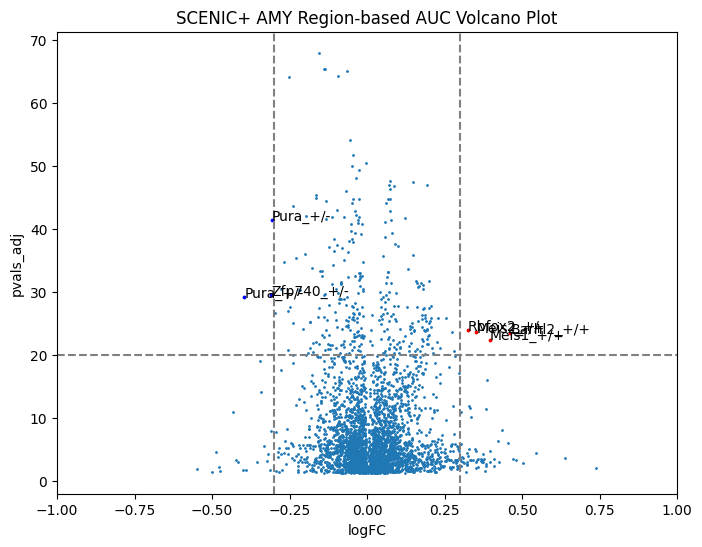

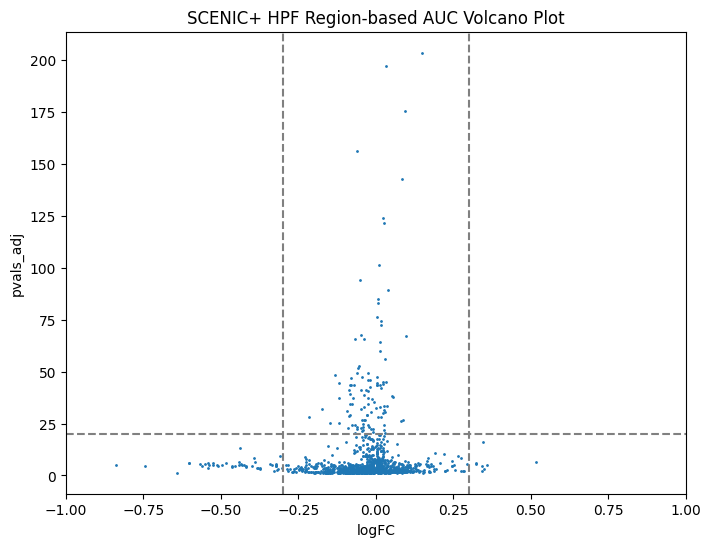

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


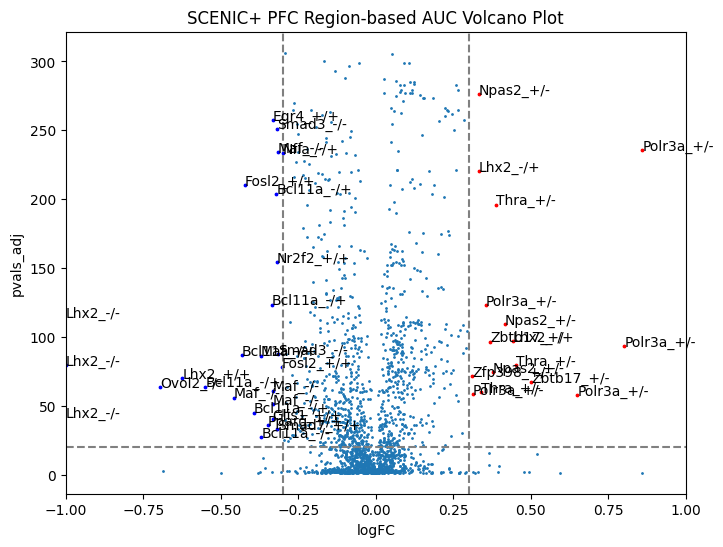

In [78]:
def draw_volcano(df, title='Volcano Plot', xlabel='Log2 Fold Change', ylabel='-Log10 Adjusted P-value', output_file=None,x_threashold=0.3, y_threshold=20):
    """
    Draw a volcano plot for the given DataFrame.
    
    Parameters:
        df: DataFrame containing 'logFC' and 'pvals_adj' columns
        title: Title of the plot
        xlabel: Label for the x-axis
        ylabel: Label for the y-axis
        output_file: If provided, save the plot to this file
    """
    plt.figure(figsize=(8, 6))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.scatter(x=df[xlabel],y=df[ylabel].apply(lambda x:-np.log10(x)),s=1,label="Not significant")

    # Scatter plot
    #plt.scatter(x=df[xlabel], y=df[ylabel].apply(lambda x: -np.log10(x)), s=1)
# highlight down- or up- regulated genes
    down = df[(df[xlabel]<=-1*x_threashold)&(df[ylabel]<=(10 ** (-1*y_threshold)))]
    up = df[(df[xlabel]>=x_threashold)&(df[ylabel]<=(10 ** (-1*y_threshold)))]
    plt.scatter(x=down[xlabel],y=down[ylabel].apply(lambda x:-np.log10(x)),s=3,label="Down-regulated",color="blue")
    plt.scatter(x=up[xlabel],y=up[ylabel].apply(lambda x:-np.log10(x)),s=3,label="Up-regulated",color="red")
    for i,r in up.iterrows():
        rx = r[xlabel] if r[xlabel] < 1 else 1
        plt.text(x=rx,y=-np.log10(r[ylabel]),s=r['TF_reg'])
    for i,r in down.iterrows():
        rx= r[xlabel] if r[xlabel] > -1 else -1
        plt.text(x=rx,y=-np.log10(r[ylabel]),s=r['TF_reg'])


    # set x and y axis limits
    plt.xlim(-1, 1)
    plt.axvline(x_threashold * -1, color="grey", linestyle="--")
    plt.axvline(x_threashold, color="grey", linestyle="--")
    plt.axhline(y_threshold, color="grey", linestyle="--")


for region in df_region_auc_filterd['region'].unique():
    df_region_auc_filterd_cell = df_region_auc_filterd[df_region_auc_filterd['region'] == region]
    draw_volcano(df_region_auc_filterd_cell, title=f'SCENIC+ {region} Region-based AUC Volcano Plot', xlabel='logFC', ylabel='pvals_adj', output_file=f'figures/{region}_region_based_AUC_volcano.png')

#draw_volcano(df_region_auc_filterd, title='SCENIC+ Region-based AUC Volcano Plot', xlabel='logFC', ylabel='pvals_adj')


In [12]:
df_sign_table = pd.read_csv('/data2st1/junyi/output/atac0627/snregulation/TFtarget_AUC_significant.csv')

In [11]:
# if AUC_T < 0 status down then us down
df_sign_table['status'] = 'up'
df_sign_table.loc[df_sign_table['AUC_t'] < 0, 'status'] = 'down'

In [12]:
df_sign_table['region'] = df_sign_table['celltype'].str.split('_').str[0]
df_sign_table['gender'] = df_sign_table['celltype'].str.split('_').str[-1]
df_sign_table['celltype.L2'] = df_sign_table['celltype'].str.split('_').str[:-1].str.join('_')

In [13]:
df_sign_table_3r = df_sign_table[(df_sign_table['region'].isin(['AMY', 'HPF', 'PFC'])) & (df_sign_table['gender']=='M')]

In [14]:
df_sign_table_3r

,celltype,AUC_p,TF,AUC_t,status,region,gender,celltype.L2
30,AMY_Ccdc3_Acvr1c_Glut_M,1.735597e-14,Bmyc,7.706127,up,AMY,M,AMY_Ccdc3_Acvr1c_Glut
31,AMY_Ccdc3_Acvr1c_Glut_M,3.951265e-06,Egr4,4.622268,up,AMY,M,AMY_Ccdc3_Acvr1c_Glut
32,AMY_Ccdc3_Acvr1c_Glut_M,3.604871e-14,Fos,7.610450,up,AMY,M,AMY_Ccdc3_Acvr1c_Glut
33,AMY_Ccdc3_Acvr1c_Glut_M,5.673057e-04,Foxp1,-3.450380,down,AMY,M,AMY_Ccdc3_Acvr1c_Glut
34,AMY_Ccdc3_Acvr1c_Glut_M,1.739000e-05,Hdac2,4.302786,up,AMY,M,AMY_Ccdc3_Acvr1c_Glut
...,...,...,...,...,...,...,...,...
14778,PFC_Vip_GABA_M,1.334233e-02,Sox11,-2.477727,down,PFC,M,PFC_Vip_GABA
14779,PFC_Vip_GABA_M,3.943958e-02,Mafg,-2.061548,down,PFC,M,PFC_Vip_GABA
14780,PFC_Vip_GABA_M,1.673134e-02,Bhlhe22,-2.395505,down,PFC,M,PFC_Vip_GABA
14781,PFC_Vip_GABA_M,1.466985e-02,Hes1,-2.443537,down,PFC,M,PFC_Vip_GABA


In [15]:
df_region_auc_filterd['celltype.L2'] = df_region_auc_filterd['celltype.L2'].str.replace('-', '_')

In [23]:
df_region_auc_filterd

,names,scores,logfoldchanges,pvals,pvals_adj,status,celltype.L2,TF,sample,sex,Neurotransmitter,nlog10_p_val_adj,de_nlog10_p_val_adjcoef,nlog10_p_val_adjcoef,region,TF_reg
0,Bclaf1_extended_+/+_(927r),10.740253,0.012137,6.586390e-27,1.211896e-24,up,AMY_Ccdc3_Acvr1c_Glut,Bclaf1,AMY_Ccdc3_Acvr1c_Glut,Male,Glut,23.916535,23.916535,23.916535,AMY,Bclaf1_+/+
2576,Zfp46_direct_+/+_(51r),10.289522,0.009343,7.856491e-25,5.224567e-23,up,AMY_Ccdc3_Acvr1c_Glut,Zfp46,AMY_Ccdc3_Acvr1c_Glut,Male,Glut,22.281950,22.281950,22.281950,AMY,Zfp46_+/+
2577,Atf7_direct_+/-_(1098r),8.670857,0.070661,4.288801e-18,1.901369e-16,up,AMY_Ccdc3_Acvr1c_Glut,Atf7,AMY_Ccdc3_Acvr1c_Glut,Male,Glut,15.720934,15.720934,15.720934,AMY,Atf7_+/-
2578,Pbx3_direct_+/+_(214r),8.537124,0.033593,1.376040e-17,4.575332e-16,up,AMY_Ccdc3_Acvr1c_Glut,Pbx3,AMY_Ccdc3_Acvr1c_Glut,Male,Glut,15.339577,15.339577,15.339577,AMY,Pbx3_+/+
2579,Etv1_direct_+/-_(1908r),8.327113,0.048196,8.283737e-17,2.203474e-15,up,AMY_Ccdc3_Acvr1c_Glut,Etv1,AMY_Ccdc3_Acvr1c_Glut,Male,Glut,14.656892,14.656892,14.656892,AMY,Etv1_+/-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13875,Bach2_extended_+/-_(1331r),8.766101,0.051465,1.849605e-18,1.895845e-17,down,PFC_Vip_GABA,Bach2,PFC_Vip_GABA,Male,Gaba,-16.722197,-16.722197,-16.722197,PFC,Bach2_+/-
13873,Bcl11a_extended_-/+_(241r),9.029505,0.128696,1.724497e-19,2.356812e-18,down,PFC_Vip_GABA,Bcl11a,PFC_Vip_GABA,Male,Gaba,-17.627675,-17.627675,-17.627675,PFC,Bcl11a_-/+
13871,Nr2f2_extended_-/+_(74r),9.835523,0.180788,7.915531e-23,3.118857e-21,down,PFC_Vip_GABA,Nr2f2,PFC_Vip_GABA,Male,Gaba,-20.506005,-20.506005,-20.506005,PFC,Nr2f2_-/+
14293,Smad3_direct_+/-_(311r),10.160388,0.044675,2.978873e-24,6.775829e-23,down,PFC_Vip_GABA,Smad3,PFC_Vip_GABA,Male,Gaba,-22.169038,-22.169038,-22.169038,PFC,Smad3_+/-


In [24]:
df_region_auc_filterd_join = df_region_auc_filterd.merge(df_sign_table_3r, on=['TF', 'celltype.L2','status','region'])

In [26]:
df_region_auc_filterd_join['Neurotransmitter'] = df_region_auc_filterd_join['celltype.L2'].map(l2nntype)

In [27]:
df_region_auc_filterd_join['n_gene_down'] = 0
df_region_auc_filterd_join['n_gene_up'] = 0
df_region_auc_filterd_join['n_gene_reg'] = 0

In [28]:
df_region_auc_filterd_join['region_nt'] = df_region_auc_filterd_join['region']+"_"+df_region_auc_filterd_join['Neurotransmitter']
df_region_auc_filterd_join['region_nt'] = df_region_auc_filterd_join['region_nt'].str.replace('Gaba', 'GABA')

In [29]:
df_region_auc_filterd_join['p_value_up'] = 1
df_region_auc_filterd_join['p_value_down'] = 1

In [30]:
from scipy.stats import hypergeom
n_universe = 30804
cellltypes = ['PFC_PFC_GABA', 
              'AMY_AMY_GABA', 
              'HIP_HIP_GABA',
              'PFC_PFC_Glut', 
              'AMY_AMY_Glut', 
              'HIP_HIP_Glut'
              ]
df_fisher_all = pd.DataFrame()
df_enahcner_all = pd.DataFrame()
for cellltype in cellltypes:
    ctname = cellltype[4:]
    ctname = ctname.replace('HIP', 'HPF')

    #df_deg_select = df_deg[df_deg['ctname'] == ctname]
    oudir = f'/data1st2/junyi/output/atac0627/scenic/{cellltype}/Snakemake'
    #scplus_mdata = mudata.read(f'{oudir}/scplusmdata.h5mu')

    #direct_er = scplus_mdata.uns["direct_e_regulon_metadata"]
    direct_er = pd.read_csv(f'{oudir}/eRegulon_direct.tsv',sep='\t')
    extended_er = pd.read_csv(f'{oudir}/eRegulons_extended.tsv',sep='\t')
    er = pd.concat([direct_er, extended_er], axis=0, ignore_index=True)
    df_auc_selected = df_region_auc_filterd_join[df_region_auc_filterd_join['region_nt'] == ctname]

    for indx,row in df_auc_selected.iterrows():
        er_selected = er[er['Region_signature_name'] == row['names']]
        df_deg_ct = df_deg.loc[(df_deg['celltype.L2'] == row['celltype.L2']) & (df_deg['gene'].isin(er_selected['Gene']))]
        df_deg_this = df_deg.loc[(df_deg['celltype.L2'] == row['celltype.L2'])]
        regulon_size = len(er_selected)
        df_deg_ct['TF'] = row['TF']
        n_gene_down =0
        n_gene_up = 0
        UP_DOW= df_deg_ct.status.value_counts()
        if 'Down' in UP_DOW.index:
            n_gene_down = UP_DOW['Down']
        if 'Up' in UP_DOW.index:
            n_gene_up = UP_DOW['Up']
        up_down_type = df_deg_this.status.value_counts()
        n_Up = 0
        n_Down = 0
        if 'Up' in up_down_type.index:
            n_Up = up_down_type['Up']
        if 'Down' in up_down_type.index:
            n_Down = up_down_type['Down']
        
        if len(df_deg_ct) == 0:
            continue
        else:
            #print(f"Processing {ctname} {row['names']} {row['TF']}")
            df_region_auc_filterd_join.iloc[indx, df_region_auc_filterd_join.columns.get_loc('n_gene_down')] = n_gene_down
            df_region_auc_filterd_join.iloc[indx, df_region_auc_filterd_join.columns.get_loc('n_gene_up')] = n_gene_up
            df_region_auc_filterd_join.iloc[indx, df_region_auc_filterd_join.columns.get_loc('n_gene_reg')] = regulon_size
            p_value_up = hypergeom.sf(n_gene_up - 1, n_universe, regulon_size, n_Up)
            p_value_down = hypergeom.sf(n_gene_down - 1, n_universe, regulon_size, n_Down)
            df_region_auc_filterd_join.iloc[indx, df_region_auc_filterd_join.columns.get_loc('p_value_up')] = p_value_up
            df_region_auc_filterd_join.iloc[indx, df_region_auc_filterd_join.columns.get_loc('p_value_down')] = p_value_down




In [31]:
df_region_auc_filterd_join.to_csv(f'/data1st2/junyi/output/atac0627/scenic/scplus_with_up_down_genes.csv')

In [ ]:
# biclustering of heatmap
df_heat_region = pd.read_csv('/data1st2/junyi/output/atac0627/regulon_analysis/scplus_region_based_AUC_filterd_selected_heatmap_40_40_cutoff8.csv',index_col=0)

In [ ]:
df_heat_region.index = df_heat_region.index.str.replace('-','_')+ '_M'

In [ ]:
df_heat_scenic = pd.read_csv('/data1st2/junyi/output/atac0627/regulon_analysis/example_go_input_3regions_heatmap_40_40_cutoff8.csv',index_col=0)

In [ ]:
df_heat_region.columns = df_heat_region.columns.str.split('_').str[0]

In [ ]:
# intersect the row index of df_heat_region and df_heat_scenic
df_heat_region_s = df_heat_region[df_heat_region.index.isin(df_heat_scenic.index)]
df_heat_scenic_s = df_heat_scenic[df_heat_scenic.index.isin(df_heat_region.index)]

In [ ]:
# intersect the columns of df_heat_region and df_heat_scenic
df_heat_region_s = df_heat_region_s[df_heat_region_s.columns.intersection(df_heat_scenic.columns)]
df_heat_scenic_s = df_heat_scenic_s[df_heat_scenic_s.columns.intersection(df_heat_region.columns)]

In [ ]:
# reoder the columns and rows of df_heat_region and df_heat_scenic
df_heat_region_s = df_heat_region_s.loc[df_heat_scenic_s.index]
df_heat_region_s = df_heat_region_s[df_heat_scenic_s.columns]

In [ ]:
# for each column, calculte the cosine similarity between the columns of df_heat_region_s and df_heat_scenic_s, ignore 0 values
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
cosine = []
n_zerosr = []
n_zerosc = []
for column in df_heat_region_s.columns:
    if column in df_heat_scenic_s.columns:
        # calculate the cosine similarity between the columns of df_heat_region_s and df_heat_scenic_s
        sim = cosine_similarity(df_heat_region_s[column].values.reshape(1, -1), df_heat_scenic_s[column].values.reshape(1, -1))
        region_n_zeros = np.count_nonzero(df_heat_region_s[column].values)
        scenic_n_zeros = np.count_nonzero(df_heat_scenic_s[column].values)
        cosine.append(sim[0][0])
        n_zerosr.append(region_n_zeros)
        n_zerosc.append(scenic_n_zeros)

df_result_cosine = pd.DataFrame({
    'scenic': df_heat_scenic_s.columns,
    'cosine_similarity': cosine,
    'n_zeros_region': n_zerosr,
    'n_zeros_scenic': n_zerosc
})

In [ ]:
df_result_cosine.sort_values(by='cosine_similarity', ascending=False, inplace=True)

In [ ]:
selected_tf=df_result_cosine[df_result_cosine['cosine_similarity'] > 0.2].scenic.tolist()

In [ ]:
# draw heatmap as suplots
# figure zize (10, 10)
sns.heatmap(df_heat_scenic_s[selected_tf], cmap='coolwarm', vmax=8, vmin=-8)

In [ ]:
sns.heatmap(df_heat_region_s[selected_tf], cmap='coolwarm', vmax=8, vmin=-8)

In [ ]:
from sklearn.cluster import SpectralCoclustering
from sklearn.metrics import consensus_score


def visual_bcluster(data, df_heat_region,n_clusters=10):

    model = SpectralCoclustering(n_clusters=n_clusters, random_state=0)
    model.fit(data)
    reordered_rows = data[np.argsort(model.row_labels_)]
    reordered_data = reordered_rows[:, np.argsort(model.column_labels_)]
    plt.matshow(reordered_data, cmap=plt.cm.Blues)
    plt.title("After biclustering; rearranged to show biclusters")
    plt.show()
    plt.close()

    for i in range(n_clusters):
        print(f"Bicluster {i}:")

        idx_row = model.row_labels_ == i
        idx_col = model.column_labels_ == i
        df_selected = df_heat_region.iloc[idx_row,idx_col]
        sns.heatmap(df_selected, cmap='coolwarm', annot=False,vmin=-8,vmax=8)
        plt.show()
        plt.close()
data = df_heat_scenic.copy().values
visual_bcluster(data, df_heat_scenic, n_clusters=10)

In [ ]:
def fisher_TF2gene(metadata_df, TF_selected, df_dar_ct,df_deg_ct):
    """
    Perform Fisher's exact test for TF-DAR-gene interactions.

    Parameters:
        metadata_df: DataFrame with columns ['TF', 'Gene', 'importance_TF2G']
        TF_col: Column name for transcription factors
        gene_col: Column name for genes
        weight_col: Column name for importance scores
    """
    # Subset the metadata for the selected TF
    direct_er_s = metadata_df[metadata_df['TF'] == TF_selected]
    df_dar_tmp = df_dar_ct.copy()
    df_deg_tmp = df_deg_ct.copy()
    df_dar_tmp['regulation'] = -1
    df_dar_tmp.loc[df_dar_tmp['de_coef']>0,'regulation'] = 1
    df_dar_reg = df_dar_tmp[['names','regulation']].rename(columns={'names': 'Region'})
    df_deg_tmp['regulation'] =  -1
    df_deg_tmp.loc[df_deg_tmp['de_coef']>0,'regulation'] = 1
    df_deg_tmp.rename(columns={'gene': 'Gene'}, inplace=True)
    direct_dar = direct_er_s.merge(df_dar_reg,how='left', left_on='Region', right_on='Region', suffixes=('', '_dar'))
    direct_dar.fillna({'regulation_dar': 0}, inplace=True)
    direct_dar_deg = direct_dar.merge(df_deg_tmp[['Gene','regulation']], how='left', left_on='Gene', right_on='Gene', suffixes=('', '_deg'))
    direct_dar_deg.fillna({'regulation_deg': 0}, inplace=True)
    direct_dar_deg['regulation_TF'] = -1
    direct_dar_deg.loc[direct_dar_deg['eRegulon_name'].str.contains('\+\/\+'), 'regulation_TF'] = 1
    #direct_dar_deg['real_regulation'] = direct_dar_deg['regulation_TF'] * direct_dar_deg['regulation_dar'] * direct_dar_deg['regulation_deg']
    direct_dar_deg['real_regulation'] = direct_dar_deg['regulation_dar'] * direct_dar_deg['regulation_deg']

    # DEG and DAR
    a = len(direct_dar_deg[direct_dar_deg['real_regulation'] == 1].drop_duplicates(subset=['Region']))
    # DAR but not DEG
    b = len(direct_dar_deg[(direct_dar_deg['real_regulation'] != 1) & (direct_dar_deg['regulation_dar'] != 0)].drop_duplicates(subset=['Region']))
    # DEG but not DAR
    c = len(direct_dar_deg[(direct_dar_deg['real_regulation'] != 1) & (direct_dar_deg['regulation_deg'] != 0)].drop_duplicates(subset=['Region']))
    # Neither DEG nor DAR
    #d = len(direct_dar_deg) - a - b - c
    d = len(direct_dar_deg[(direct_dar_deg['regulation_dar'] == 0) & (direct_dar_deg['regulation_deg'] == 0)].drop_duplicates(subset=['Region']))
    odds_ratio, p_value = fisher_exact([[a, b], [c, d]], alternative='two-sided')
    return odds_ratio, p_value


In [ ]:
cellltypes = ['PFC_PFC_GABA', 
              'AMY_AMY_GABA', 
              'HIP_HIP_GABA',
              'PFC_PFC_Glut', 
              'AMY_AMY_Glut', 
              'HIP_HIP_Glut'
              ]
df_fisher_all = pd.DataFrame()
df_enahcner_all = pd.DataFrame()
for cellltype in cellltypes:
    ctname = cellltype[4:]
    df_deg_select = df_deg[df_deg['ctname'] == ctname]
    oudir = f'/data1st2/junyi/output/atac0627/scenic/{cellltype}/Snakemake'
    #scplus_mdata = mudata.read(f'{oudir}/scplusmdata.h5mu')

    #direct_er = scplus_mdata.uns["direct_e_regulon_metadata"]
    direct_er = pd.read_csv(f'{oudir}/eRegulon_direct.tsv',sep='\t')
    direct_er.sort_values(['importance_TF2G'], ascending=False, inplace=True)
    deg = direct_er[direct_er.Gene.isin(df_deg_select.gene)].copy()
    visualize_regulatory_network(deg,importance_col='importance_TF2G',weight_col='rho_TF2G',df_deg=df_deg_select, top_n=min(400,len(deg)),title='DEG Regulatory Network',output_html=f'figures/{cellltype}_deg_network.html')

    dar = direct_er[direct_er['Region'].isin(df_dar['names'].unique())].copy()
    visualize_regulatory_network(dar,importance_col='importance_TF2G',weight_col='rho_TF2G',df_deg=df_deg_select, top_n=min(250,len(dar)),title='DAR Regulatory Network',output_html=f'figures/{cellltype}_dar_network.html')


    TF_gcount = pd.DataFrame(direct_er.groupby(['TF']).nunique()['Gene'].sort_values(ascending=False))
    TF_degcount = pd.DataFrame(deg.groupby(['TF']).nunique()['Gene'])

    TF_rcount = pd.DataFrame(direct_er.groupby(['TF']).nunique()['Region'].sort_values(ascending=False))
    TF_darcount = pd.DataFrame(dar.groupby(['TF']).nunique()['Region'])

    df_importance = TF_degcount.merge(TF_gcount, left_index=True, right_index=True, how='right', suffixes=('_deg', '_all')).fillna(0)
    df_importance['deg_ratio'] = df_importance['Gene_deg'] / df_importance['Gene_all']
    df_importance.sort_values('deg_ratio', ascending=False, inplace=True)
    df_importance['ctname'] = ctname
    df_rimportance = TF_darcount.merge(TF_rcount, left_index=True, right_index=True, how='right', suffixes=('_deg', '_all')).fillna(0)
    df_rimportance['dar_ratio'] = df_rimportance['Region_deg'] / df_rimportance['Region_all']
    df_importance = df_importance.merge(df_rimportance, left_index=True, right_index=True, how='left', suffixes=('', '_TF2G'))
    df_importance.to_csv(f'figures/{cellltype}_TF_deg_ratio.csv')
    ca_df = direct_er[direct_er.Gene.isin(ca_genes)].copy()
    visualize_regulatory_network(ca_df,importance_col='importance_TF2G',weight_col='rho_TF2G',df_deg=df_deg_select, top_n=len(ca_df),title='Cacn Regulatory Network',output_html=f'figures/{cellltype}_ca_network.html')

    ligand_df = direct_er[direct_er.Gene.isin(ligand)].copy()

    visualize_regulatory_network(ligand_df,importance_col='importance_TF2G',weight_col='rho_TF2G', top_n=len(ligand_df),title='Ligand Regulatory Network',df_deg=df_deg_select,output_html=f'figures/{cellltype}_ligand_network.html')

    atp_df = direct_er[direct_er.Gene.isin(respriotory)].copy()

    visualize_regulatory_network(atp_df,importance_col='importance_TF2G',weight_col='rho_TF2G',df_deg=df_deg_select, top_n=len(atp_df),title='Respiratory Regulatory Network',output_html=f'figures/{cellltype}_respiratory_network.html')

    receptor_df = direct_er[direct_er.Gene.isin(receptor)].copy()

    visualize_regulatory_network(receptor_df,importance_col='importance_TF2G',weight_col='rho_TF2G', top_n=len(receptor_df),title='Receptor Regulatory Network',df_deg=df_deg_select,output_html=f'figures/{cellltype}_receptor_network.html')


    df_dar_ctgrn = df_dar_select.merge(direct_er, left_on='names', right_on='Region', how='inner')
    df_c_enhancer = df_dar_ctgrn[df_dar_ctgrn.primary_region.isin(['distal','downstream','intergenic'])]
    df_target_promoters = df_dar_select[(df_dar_select['gene'].isin(df_c_enhancer.Gene)) & (df_dar_select['primary_region'] == 'promoter')]
    df_target_promoters = df_target_promoters[['names','de_coef','de_pval','gene']]
    df_target_promoters.rename(columns={'names': 'promoter_region','de_coef': 'promoter_de_coef','de_pval': 'promoter_de_pval'}, inplace=True)
    df_protential_enhancer = df_c_enhancer.merge(df_target_promoters, left_on='Gene', right_on='gene', how='inner')
    df_protential_enhancer = df_protential_enhancer[df_protential_enhancer.de_coef * df_protential_enhancer.promoter_de_coef > 0]
    df_protential_enhancer.to_csv(f'figures/{cellltype}_potential_enhancer.csv', index=False)
    df_enahcner_all = pd.concat([df_enahcner_all, df_protential_enhancer], axis=0, ignore_index=True)

    df_protential_enhancer.rename(columns={'regulation_y':'regulation'}, inplace=True)
    enhancerdf = df_protential_enhancer[ca_df.columns]
    visualize_regulatory_network(enhancerdf,importance_col='importance_TF2G',weight_col='rho_TF2G', top_n=min(len(enhancerdf),300),title='Enhancer Regulatory Network',
                                 df_deg=df_deg_select,output_html=f'figures/{cellltype}_enhancer_network.html')

    

    odds_ratios = []
    p_values = []

    df_dar_select = df_dar[df_dar['ctname'] == ctname]

    for TF in direct_er['TF'].unique():
        odds_ratio, p_value = fisher_TF2gene(direct_er, TF, df_dar_select, df_deg_select)
        # print(f"TF: {TF}, Odds Ratio: {odds_ratio:.2f}, p-value: {p_value:.4e}")
        odds_ratios.append(odds_ratio)
        p_values.append(p_value)
    fisher_df = pd.DataFrame({
        'TF': direct_er['TF'].unique(),
        'Odds Ratio': odds_ratios,
        'p-value': p_values
    })
    fisher_df['ctname'] = cellltype

    fisher_df = fisher_df.merge(df_importance, on='TF', how='left')

    df_fisher_all = pd.concat([df_fisher_all, fisher_df], axis=0, ignore_index=True)


    # df_protential_enhancer.rename(columns={'gene_y': 'gene'}, inplace=True)
    # visualize_regulatory_network(df_protential_enhancer,importance_col='importance_TF2G',weight_col='rho_TF2G', top_n=len(df_protential_enhancer),title='Enhancer Regulatory Network',
    #                          df_deg=df_deg_select,output_html=f'figures/{cellltype}_enhancer_network.html')



In [ ]:
bed_encode = "/data2st1/junyi/output/atac0416/cCRE/mm10-cCREs.bed"


In [ ]:
df_encode = pd.read_csv(bed_encode, sep='\t', header=None)

In [ ]:
def intersect_bed_objects(bed_file1, bed_file2):
    bed1 = bed_file1.sort()
    bed2 = bed_file2.sort()

    # Intersect and split regions
    # Retain annotations from bed_file2 for overlapping regions
    merged = bed1.intersect(bed2, wa=True, wb=True)#.saveas("output/temp_intersect.bed")

    # Split non-overlapping regions from bed_file1
    non_overlapping = bed1.subtract(bed2)#.saveas("output/temp_non_overlapping.bed")

    return merged, non_overlapping


In [ ]:
df_enahcner_all.rename(columns={'gene_y': 'gene'}, inplace=True)

In [ ]:
df_enahcner_all.to_csv('figures/potential_enhancer_all.csv', index=False)

In [ ]:
pcolumn = 'ctname'
df_enahcner_all.groupby(pcolumn).size().reset_index(name='counts').set_index(pcolumn).plot.pie(
    y='counts',
    autopct=lambda p: f'{p:.1f}%' if p >= 5 else '',
    legend=False
)

In [ ]:
df_fisher_all.sort_values('p-value', ascending=True, inplace=True)

In [ ]:
# adjust p-values
pvals = df_fisher_all['p-value'].values
from statsmodels.stats.multitest import multipletests
_, pvals_corrected, _, _ = multipletests(pvals, method='fdr_bh')
df_fisher_all['pval_adj'] = pvals_corrected                                                                                                                         

In [ ]:
df_fisher_all.to_csv('figures/fisher_TF2gene.csv', index=False)

In [ ]:
df_fisher_all

In [ ]:
# select pvalue < 0.05 and odds ratio > 0.1
df_fisher_s = df_fisher_all[(df_fisher_all['pval_adj'] < 0.05) & (df_fisher_all['Odds Ratio'] > 0.1)]

In [ ]:
df_fisher_s['ct'] = df_fisher_s['ctname_y'].apply(lambda x: x.split('_')[1])

In [ ]:
df_top = df_fisher_s.groupby(['TF','ct']).count()['ctname_x'].sort_values(ascending=False).reset_index()

In [ ]:
subset_name = list(set(df_top.head(10).TF.values))

In [ ]:
df_fisher_s

In [ ]:
df_deg_glut = pd.read_csv('/home/junyichen/code/scmmd/data/degs/Memento_Glut_DEGs_each_region_diff_gender_v1.csv',index_col=0)
df_deg_gaba = pd.read_csv('/home/junyichen/code/scmmd/data/degs/Memento_GABA_DEGs_each_region_diff_gender_v1.csv',index_col=0)
df_deg_glut['ctname'] = df_deg_glut['region'] + '_Glut'
df_deg_gaba['ctname'] = df_deg_gaba['region'] + '_GABA'
df_deg = pd.concat([df_deg_glut,df_deg_gaba],axis=0,ignore_index=True)
df_deg_select = df_deg[(df_deg.de_pval<0.05) & (df_deg.gender=="M")]
df_deg_select['condition'] = 'MW'
df_deg_select.loc[df_deg_select.de_coef>0,'condition'] = 'MC'

In [ ]:
df_gene_select = df_deg_select[df_deg_select['gene'].isin(df_enahcner_all.Gene.unique())].copy()

In [ ]:
df_heatmap = df_gene_select.pivot_table(index='ctname', columns='gene', values='de_coef', aggfunc='mean').fillna(0).clip(lower=-1, upper=1)

In [ ]:
sns.heatmap(df_heatmap, cmap='coolwarm', center=0)

In [ ]:
df_deg_select

In [ ]:
df_tf_select = df_deg_select[df_deg_select['gene'].isin(df_fisher_s.TF.unique())].copy()
df_tf = df_tf_select.pivot_table(index='ctname', columns='gene', values='de_coef', aggfunc='mean').fillna(0).clip(lower=-1, upper=1)

In [ ]:
sns.heatmap(df_tf, cmap='coolwarm', center=0)

In [ ]:
import glob as glob
df_globs = glob.glob('figures/*_TF**csv')

In [ ]:
all_df = pd.DataFrame()
for df_glob in df_globs:
    df = pd.read_csv(df_glob).head(20)
    
    all_df = pd.concat([all_df, df], axis=0, ignore_index=True)

In [ ]:
all_df.TF

In [ ]:
all_df["NT"] = all_df["ctname"].str.split('_').str[1]
all_df["Region"] = all_df["ctname"].str.split('_').str[0]

In [ ]:
all_df.groupby(['TF']).nunique()['ctname'].reset_index().sort_values('ctname', ascending=False).to_csv('figures/TF_allcount.csv', index=False)

In [ ]:
all_df.groupby(['TF','NT']).nunique()['ctname'].reset_index().sort_values('ctname', ascending=False).to_csv('figures/TF_NTcount.csv', index=False)

In [ ]:


eRegulon_gene_AUC = anndata.concat(
    [scplus_mdata["direct_gene_based_AUC"], scplus_mdata["extended_gene_based_AUC"]],
    axis = 1,
)


In [ ]:
scplus_mdata['direct_region_based_AUC'].var

In [ ]:
scplus_mdata['direct_region_based_AUC']

In [ ]:
scplus_mdata.uns["direct_e_regulon_metadata"].to_csv(
    "/data1st2/junyi/output/atac0627/scenic/AMY_AMY_Glut/direct_e_regulon_metadata.csv"
)


In [ ]:
eRegulon_gene_AUC.obs = scplus_mdata.obs.loc[eRegulon_gene_AUC.obs_names]


In [ ]:
sc.pp.neighbors(eRegulon_gene_AUC, use_rep = "X")


In [ ]:
sc.tl.umap(eRegulon_gene_AUC)


In [ ]:
eRegulon_gene_AUC.obs['celltype.L2'] = eRegulon_gene_AUC.obs.index.str.split("_").str[:-1].str.join("_")

In [ ]:
sc.pl.umap(eRegulon_gene_AUC, color = ['celltype.L2'])


In [ ]:
scplus_mdata.obs['celltype.L2'] = scplus_mdata.obs.index.str.split("_").str[:-1].str.join("_")

In [ ]:
from scenicplus.RSS import (regulon_specificity_scores, plot_rss)


In [ ]:
rss = regulon_specificity_scores(
    scplus_mudata = scplus_mdata,
    variable = "celltype.L2",
    modalities = ["direct_gene_based_AUC", "extended_gene_based_AUC"]
)


In [ ]:
plot_rss(
    data_matrix = rss,
    top_n = 3,
    num_columns = 3
)

In [ ]:
from scenicplus.plotting.dotplot import heatmap_dotplot
heatmap_dotplot(
    scplus_mudata = scplus_mdata,
    color_modality = "direct_gene_based_AUC",
    size_modality = "direct_region_based_AUC",
    group_variable = "celltype.L2",
    eRegulon_metadata_key = "direct_e_regulon_metadata",
    color_feature_key = "Gene_signature_name",
    size_feature_key = "Region_signature_name",
    feature_name_key = "eRegulon_name",
    sort_data_by = "direct_gene_based_AUC",
    orientation = "horizontal",
    figsize = (16, 5)
)